In [14]:
source(file.path("..", "R", "init.R"))
init(where = "local")

suppressMessages({
  library(dplyr)
  library(ggplot2)
  library(reticulate)
  library(lhs)
  library(future.apply)
  library(future)
  library(parallel)
})

[1] "Config for local!"


# Problem

In [3]:
source("problem.R")
problem

$num_vars
[1] 17

$names
 [1] "phen_VegTherTimeResp_X3"   "phen_RepTherTimeResp_X3"  
 [3] "phen_VegPhoMod_X1"         "phen_RepPhoMod_X1"        
 [5] "phen_VegetativeTarget"     "phen_EarlyFloweringTarget"
 [7] "phen_EarlyPodDevTarget"    "phen_FractGrainFill"      
 [9] "phen_MidGrainFill"         "phen_EntGrainFill"        
[11] "phen_Maturing"             "phen_Ripening"            
[13] "leaf_RUE"                  "leaf_AreaLargLeaf"        
[15] "leaf_Phyllochron"          "leaf_ExtinctionCoef_Y1"   
[17] "grain_HarvIndex"          

$bounds
$bounds[[1]]
[1] 21 39

$bounds[[2]]
[1] 21 39

$bounds[[3]]
[1] 10.5 14.5

$bounds[[4]]
[1] 10.5 14.5

$bounds[[5]]
[1] 200 600

$bounds[[6]]
[1] 100 300

$bounds[[7]]
[1]  70 210

$bounds[[8]]
[1] 0.035 0.065

$bounds[[9]]
[1] 0.35 0.65

$bounds[[10]]
[1] 250 750

$bounds[[11]]
[1] 35 65

$bounds[[12]]
[1] 35 65

$bounds[[13]]
[1] 0.8 1.6

$bounds[[14]]
[1] 0.004 0.008

$bounds[[15]]
[1] 35 65

$bounds[[16]]
[1] 0.4 0.8

$bounds[[17]]
[1] 0.35 0.65

# Generate samples

,id,phen_VegTherTimeResp_X3,phen_RepTherTimeResp_X3,phen_VegPhoMod_X1,phen_RepPhoMod_X1,phen_VegetativeTarget,phen_EarlyFloweringTarget,phen_EarlyPodDevTarget,phen_FractGrainFill,phen_MidGrainFill,phen_EntGrainFill,phen_Maturing,phen_Ripening,leaf_RUE,leaf_AreaLargLeaf,leaf_Phyllochron,leaf_ExtinctionCoef_Y1,grain_HarvIndex
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,36.11267,29.53080,11.50042,11.49208,575.1525,225.2244,183.2941,0.04552226,0.4192195,741.138,50.86901,55.77406,0.8645708,0.007603729,64.58428,0.6434637,0.3954061
2,2,35.66788,29.53080,11.50042,11.49208,575.1525,225.2244,183.2941,0.04552226,0.4192195,741.138,50.86901,55.77406,0.8645708,0.007603729,64.58428,0.6434637,0.3954061
3,3,36.11267,32.93305,11.50042,11.49208,575.1525,225.2244,183.2941,0.04552226,0.4192195,741.138,50.86901,55.77406,0.8645708,0.007603729,64.58428,0.6434637,0.3954061
4,4,36.11267,29.53080,10.51773,11.49208,575.1525,225.2244,183.2941,0.04552226,0.4192195,741.138,50.86901,55.77406,0.8645708,0.007603729,64.58428,0.6434637,0.3954061
5,5,36.11267,29.53080,11.50042,10.63682,575.1525,225.2244,183.2941,0.04552226,0.4192195,741.138,50.86901,55.77406,0.8645708,0.007603729,64.58428,0.6434637,0.3954061
6,6,36.11267,29.53080,11.50042,11.49208,315.0525,225.2244,183.2941,0.04552226,0.4192195,741.138,50.86901,55.77406,0.8645708,0.007603729,64.58428,0.6434637,0.3954061


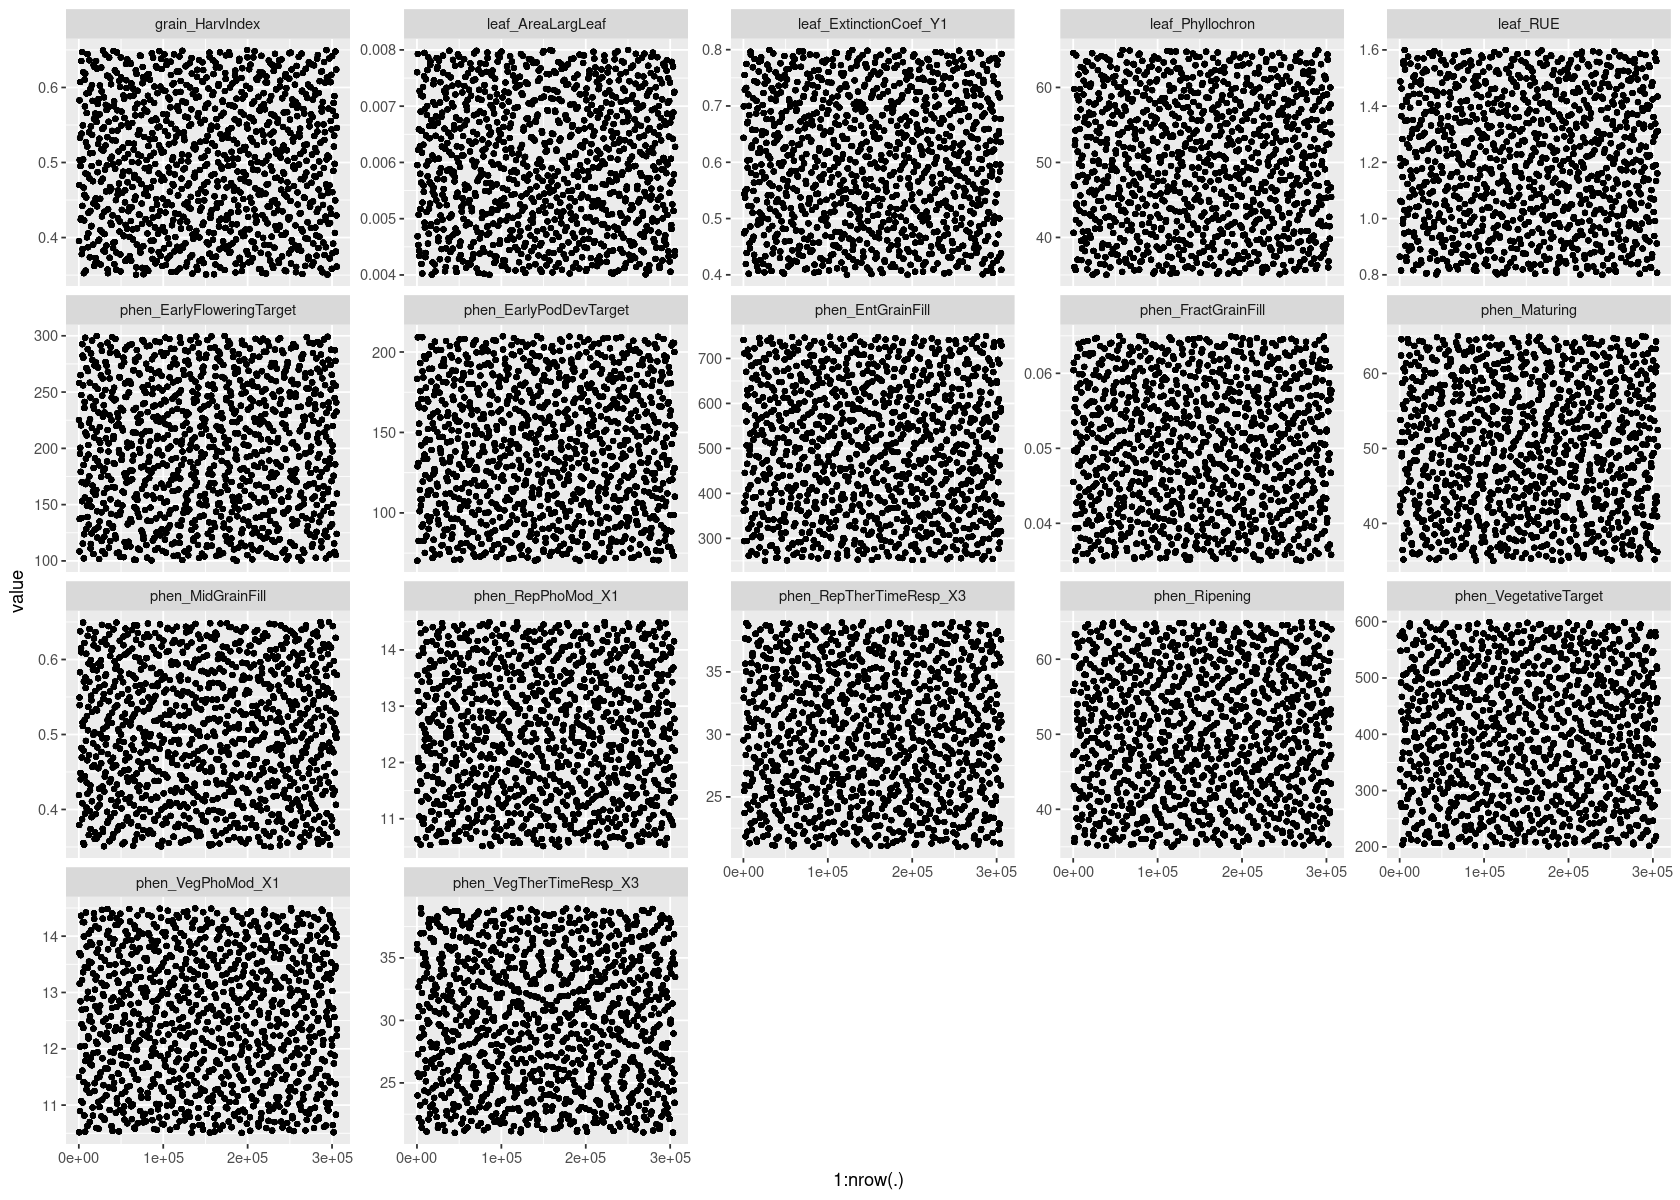

In [4]:
# method = "LHS"
# method = "FAST"
method = "SOBOL"
N_SAMPLES = 500L
samples_df <- generate_samples_csv(problem, method, N_SAMPLES)
head(samples_df)

options(repr.plot.width = 14, repr.plot.height = 10)
plot_samples_distribution(samples_df)

# Generate sensi folder and apsimx sims

In [5]:
source(file.path("..", "R", "init.R"))
init(where = "local")

# Create sensi folder
timestamp <- format(Sys.time(), "%Y%m%d_%H%M%S")
sensi_tmp_folder <- create_tmp_dir_from_base_folder(paste0("tmp_sensi_", timestamp))
print(sensi_tmp_folder)

# Copy problem to sensi folder
saveRDS(problem, file.path(sensi_tmp_folder, "problem.rds"))

# Save samples to sensi folder
write.csv(samples_df, file.path(sensi_tmp_folder, "samples.csv"), row.names = FALSE)

[1] "Config for local!"
[1] "/home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_sensi_20250123_171522"


# Generate apsimx files

In [15]:
# Generate apsimx files
generate_apsimx_from_df(
  samples_df = samples_df,
  folder = sensi_tmp_folder,
  # sensit_base_sim_filepath = file.path(getwd(), "Soy-BR-sensit.apsimx"),
  # sensit_base_sim_filepath = file.path(BASE_SIMULATIONS_FOLDER, "Soy-BR-fields-MG6.apsimx"),
  sensit_base_sim_filepath = file.path(BASE_SIMULATIONS_FOLDER, "Soy-BR-fields-MG06BR_replac.apsimx"),
  runs_only_some = TRUE,
  N = 30,
  parallel = TRUE
)
print_stats_of_folder(sensi_tmp_folder)

[1] "Number of csvs: 0"
[1] "Number of apsimxs: 30"
[1] "Some files:"
[1] "    /home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_sensi_20250123_171522/simulation1.apsimx" 
[2] "    /home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_sensi_20250123_171522/simulation10.apsimx"
[3] "    /home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_sensi_20250123_171522/simulation11.apsimx"
[4] "    /home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_sensi_20250123_171522/simulation12.apsimx"
[5] "    /home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_sensi_20250123_171522/simulation13.apsimx"
[1] "/home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_sensi_20250123_171522/simulation1.apsimx" 
[2] "/home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_sensi_20250123_171522/simulation10.apsimx"
[3] "/home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_s

# Run all apsimx from folder

In [16]:
source(file.path("..", "R", "init.R"))
init(where = "local")

run <- run_apsimx_from_folder(
  folder = sensi_tmp_folder,
  force_rerun = TRUE,
  runs_only_some = FALSE,
  cleanup = TRUE,
  # N = 15,
  # ids_to_run = c(1, 20, 10, 11, 16, 15),
  parallel = TRUE,
  dry_run = TRUE
)

[1] "Config for local!"
[1] "Running file /home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_sensi_20250123_171522/simulation1.apsimx"
[1] "Running file /home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_sensi_20250123_171522/simulation10.apsimx"
[1] "Running file /home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_sensi_20250123_171522/simulation11.apsimx"
[1] "Running file /home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_sensi_20250123_171522/simulation12.apsimx"
[1] "Running file /home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_sensi_20250123_171522/simulation13.apsimx"
[1] "Running file /home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_sensi_20250123_171522/simulation14.apsimx"
[1] "Running file /home/luanabeckerdaluz/git/luanabeckerdaluz/apsimx-sensitivity/tmp/tmp_sensi_20250123_171522/simulation15.apsimx"
[1] "Running file /home/luanabeckerdaluz/git/luanabec